<a href="https://colab.research.google.com/github/pablocalvo7/Symmetry_Seeker_NN/blob/main/Notebook_symmetry_seeker_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

**Finding discrete symmetry groups via Machine Learning**
---
Pablo Calvo-Barlés,$^{1, 2}$ Sergio G. Rodrigo,$^{1, 3}$ Eduardo Sánchez-Burillo,$^{4}$ and Luis Martín-Moreno$^{1, 2}$

---
+ $^{1}$ Instituto de Nanociencia y Materiales de Aragón (INMA), CSIC-Universidad de Zaragoza, 50009 Zaragoza, Spain
+ $^{2}$ Departamento de Física de la Materia Condensada, Universidad de Zaragoza, 50009 Zaragoza, Spain
+ $^{3}$ Departamento de Física Aplicada, Universidad de Zaragoza, 50009 Zaragoza, Spain
+ $^{4}$ PredictLand S.L., 50001 Zaragoza, Spain

**Abstract**
---

+ This Jupyter notebook provides an implementation of the **Symmetry Seeker Neural Network (SSNN)** model based on Tensorflow-Keras. The NN model has been designed to identify discrete symmetries. With this code you will be able to:
 - Determine the matrix representation of all elements within a system's symmetry group by solving a supervised learning task.
 - Solve inverse design problems that entail symmetry-related, multivalued solutions.
+ In this notebook, we illustrate the functionality of the SSNN model by solving an inverse problem and unveiling their symmetries. The task involves determining the value of $z$ (a complex number) based on the given functional relationship $w=z^3$, where $w$ is also a complex number. With the SSNN method will get the group of symmetries for this transformation.

# **General description**
---
+ Statement of the problem: we consider the function $\vec{y}(\vec{x})$, where $\vec{x} \in \mathbb{R}^n$ are some parameters of a given phyisical system and $\vec{y} \in \mathbb{R}^m$ are some measurable magnitudes. Given the $n \times n$ matrix representation of a group $\{ \hat{D}_1,...,\hat{D}_K \}$ of order $K$, $\vec{y}(\vec{x})$ is symmetric under the action of the group:

\begin{equation}
\Leftrightarrow \vec{y}(\vec{x}) = \vec{y}(\hat{D}_{\alpha}\vec{x}) \; \forall \vec{x}, \alpha.
\end{equation}

+ Goal of the SSNN method: Find predictions for $\{ \hat{D}^{\mathrm{NN}}_{\alpha}\}_{\alpha = 1}^K$ of the unknown ground truth symmetry matrices $\{ \hat{D}_{\alpha}\}_{\alpha = 1}^K$, provided only with $N$ training samples $\{ ( \vec{x}_i , \vec{y}_i ) \}_{i=1}^N$ (where $\vec{y}_i = \vec{y}(\vec{x}_i)$).


# **Symmetric Seeker Neural Network (SSNN) model**
---

+ Input: $\vec{y}$ (measurable magnitudes)
+ Output: $M$ predictions of the physical parameters $\{ \vec{x}^{(\alpha)}_{\mathrm{NN}} \}_{\alpha=1}^{M}$. It is intended to return the inverse function $\vec{y}^{-1}$, which is multivalued because of the symmetry.
+ Architecture:
  + Standard NN: non-linear hidden layers plus a latent layer with $n$ neurons. It returns the latent vector $\vec{x}^{(0)}_{\mathrm{NN}}$.
  + Branches: multi-layer of $M$ trainable linear transformations $\hat{W}_{\alpha}$. These are $n \times n$ matrices such that $\vec{x}^{(\alpha)}_{\mathrm{NN}} = \hat{W}_{\alpha} \vec{x}^{(0)}_{\mathrm{NN}}$.

+ Custom loss function:
\begin{equation}
    L = \frac{1}{2N} \sum_i \min_{\alpha} L_i^{(\alpha)}.
\end{equation}
where the mean square error of the prediction $\vec{x}^{(\alpha)}_{\mathrm{NN}}(\vec{y}_i)$ with respect to the training sample $\vec{x}_i$ is

\begin{equation}
    L_i^{(\alpha)} = || \vec{x}_i - \vec{x}^{(\alpha)}_{\mathrm{NN}}(\vec{y}_i)||^2.
\end{equation}

**SSNN schematics**
--

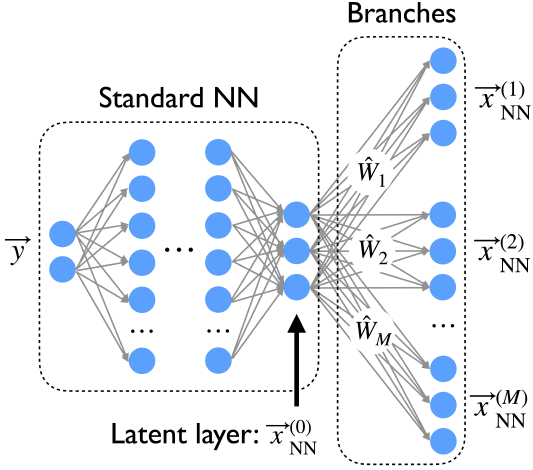

# **Python implementation**



List of important variables used in this code:

- *n*: number of physical features (dimensionality of $\vec{x}$).
- *M*: number of branches.
- *x_true*: training samples $\vec{x}_i$.
- *x_NN*: SSNN predictions, i.e., $\vec{x}_{\mathrm{NN}}^{(\alpha)}$ for $\alpha = 1,...,M$.






# Symmetric Seeker Neural Network (SymSeekerNN) class

## Main imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.engine import compile_utils

## Class definition

In [ ]:
class SymSeekerNN(tf.keras.Model):
    '''
    Symmetry Seeker Neural Network class.
    This class inherits from the tf.keras.Model class as a subclass.
    - The following methods have been overridden in this class: compile(),call(),get_config() and
    from_config()
    - New methods not related with the SSNN method: summary(),evaluate_loss() and
    load_model()
    - The SSNN method core contains:
    1) The Keras model of the SSNN. The standard layers can be customly added by the user, whereas the latent layer and branches are fixed by this class.
    2) The loss function "symmetry_loss" to train the SSNN (eq. 2 in Calvo-Barlés et al.).
    3) The function "obtain_list_D_NN" that obtains the predicted symmetry matrices D_NN from the SSNN (eq. 5 in Calvo-Barlés et al.).
    4) Two functions, "calculate_d_closed" and "calculate_d_inv", that obtain the group metrics (eq. 7 and 8 in Calvo-Barlés et al.) as function of the matrices D_NN obtained with the previous function.
    5) The function "obtain_activity_single_branch" that calculates the activity A_alpha (defined below in this notebook) for a single branch alpha.
    6) The function "obtain_list_activities" that returns a list of activities of every branch in the SSNN.
    '''
    def __init__(self,n,M,
                 input_layer=None,
                 standard_layers=None,
                 branches_output=None,
                 model_saved=None):
        super(SymSeekerNN, self).__init__()

        self.n=n
        self.M=M
        #try... except
        if(model_saved!=None):
          self.model=model_saved
        else:
          self.input_layer=input_layer
          self.standard_layers=standard_layers
          # Latent layer
          self.latent_layer = standard_layers.layers[-1]
          self.latent_layer.units=(self.n)
          # Branches
          self.branches_output = branches_output
          self.branches_output.units=int(self.n*self.M)
          self.branches_output.use_bias= False
          self.branches_output.activation=None
          self.model=Sequential([self.input_layer,
                                self.standard_layers,
                                self.branches_output])

    '''
    Overriden methods
    '''
    def call(self, inputs):
        # The usual forward pass of the model
        return self.model(inputs)

    def compile(self, optimizer='adam',**kwargs):
        super(SymSeekerNN, self).compile(**kwargs)
        self.optimizer= optimizer
        # Uses symmetry_loss
        self.loss=self.symmetry_loss(self.M,self.n)
        loss_weights=None
        self.output_names = None
        self.model.compile(loss=self.loss)
        self.compiled_loss = compile_utils.LossesContainer(
          self.loss, loss_weights, output_names=self.output_names)

    def get_config(self):
        config = super(SymSeekerNN, self).get_config()
        # Add any custom configurations to the config dictionary
        custom_methods = {
            'summary' : self.summary.__name__,
            'symmetry_loss'  : self.symmetry_loss.__name__,
            'calculate_d_closed': self.calculate_d_closed.__name__,
            'calculate_d_inv'   : self.calculate_d_inv.__name__,
            'obtain_list_D_NN' : self.obtain_list_D_NN.__name__,
            '_list_winner_branches' : self._list_winner_branches.__name__,
            'obtain_activity_single_branch' : self.obtain_activity_single_branch.__name__,
            'obtain_list_activities' : self.obtain_list_activities.__name__
        }
        config['custom_methods'] = custom_methods
        return config

    @classmethod
    def from_config(cls, config):
        # Create an instance of the custom model class using the provided config
        model = cls()
        # Perform any additional customizations if required
        return model

    '''
    New methods not related with finding symmetries
    '''
    def summary(self):
       return self.model.summary()

    def evaluate_loss(self,x_true,x_NN):
       return self.loss(x_true,x_NN)

    @classmethod
    def load_model(cls, path,n,M):
        model_saved=models.load_model(path,compile=False)
        # Create an instance of the custom model class using the provided config
        model = cls(n,M,model_saved=model_saved)
        return model

    '''
    Core of the SSNN method
    '''
    def symmetry_loss(self,M,n):
      '''
      INPUT:
      - M: number of branches
      - n: number of physical features
      - x_true: batch of training samples x. It is an array of size (minib_size x n*M) The training samples are M times tiled along the axis 1 in order to fit with the SSNN prediction.
      - x_NN: batch size of predictions. It contains the predictions of each branch. Thus, its size is also (minib_size x n*M).

      OUTPUT:
      - sym_loss: loss function calculated for the batch.
      '''
      def sym_loss(x_true,x_NN):

          mbs = tf.shape(x_NN)[0]

          x_true = tf.cast(x_true, dtype = 'float32')
          x_NN = tf.cast(x_NN, dtype = 'float32')

          diff_squared = (x_NN-x_true)*(x_NN-x_true)
          sum_kernel = tf.constant(np.ones((1,n)),tf.float32)
          loss_matrix = tf.nn.conv2d(tf.reshape(diff_squared,(1,mbs,int(n*M),1)),tf.reshape(sum_kernel,(1,n,1,1)),strides=[1,n],padding='VALID')
          loss_matrix = tf.reshape(loss_matrix,(mbs,M))

          loss_matrix = 0.5*loss_matrix
          loss_vector = tf.math.reduce_min(loss_matrix, axis=1)
          mbs = tf.cast(mbs, dtype = 'float32')
          loss = tf.math.reduce_sum(loss_vector)/mbs
          return loss
      return sym_loss

    def obtain_list_D_NN(self,index_reference):
      '''
      INPUT:
      - index_reference: index of the reference matrix (from 0 to M-1).

      OUTPUT:
      - list_mats: list of predicted symmetry matrices D_NN.
      '''
      w = self.model.get_weights()
      W_ref_inv = np.linalg.inv(w[-1][0:self.n,index_reference*self.n:(index_reference+1)*self.n])
      list_mats = []
      for alpha in range(self.M):
          W = w[-1][0:self.n,alpha*self.n:(alpha+1)*self.n]
          list_mats.append( np.matmul(W_ref_inv,W) )
      return list_mats

    def calculate_d_closed(self,index_reference):
      '''
      INPUT:
      - index_reference
      OUTPUT:
      - d_closed: closed metric
      '''
      list_mats=self.obtain_list_D_NN(index_reference)
      sum = 0.0
      for W_alpha in list_mats:
          for W_beta in list_mats:
              Wab = np.matmul(W_alpha,W_beta)
              list_d_gamma = []
              for W_gamma in list_mats:
                  Wab_Wg = Wab - W_gamma
                  list_d_gamma.append( np.sum( np.absolute( Wab_Wg ) ) )
              sum = sum + min(list_d_gamma)
      d_closed = sum/(self.n*self.n*self.M*self.M)
      return d_closed

    def calculate_d_inv(self,index_reference):
      '''
      INPUT:
      - index_reference
      OUTPUT:
      - d_inv: inverse metric
      '''
      list_mats=self.obtain_list_D_NN(index_reference)
      sum = 0.0
      for W_alpha in list_mats:
          Wa_inv = np.linalg.inv(W_alpha)
          list_d_gamma = []
          for W_gamma in list_mats:
              Wa_inv_Wg = Wa_inv - W_gamma
              list_d_gamma.append( np.sum( np.absolute (Wa_inv_Wg ) ) )
          sum = sum + min(list_d_gamma)
      d_inv = sum/(self.n*self.n*self.M)
      return d_inv

    def _list_winner_branches(self,x_true,x_NN):
        '''
        INPUT:
        - x_true: training data (N samples)
        - x_NN: SSNN predictions of the training data (N)
        OUTPUT:
        - list_winner_br: array of size N whose entries are the indices of the winner branch (minimum MSE) for each training sample.
        '''
        N = np.shape(x_true)[0]

        loss_matrix = (x_NN[:,0]-x_true[:,0])*(x_NN[:,0]-x_true[:,0])
        for j in range(1,self.n):
            loss_matrix = loss_matrix + (x_NN[:,j]-x_true[:,j])*(x_NN[:,j]-x_true[:,j])

        for i in range(1,self.M):
            loss_column = (x_NN[:,self.n*i]-x_true[:,0])*(x_NN[:,self.n*i]-x_true[:,0])
            for j in range(1,self.n):
                loss_column = loss_column + (x_NN[:,self.n*i+j]-x_true[:,j])*(x_NN[:,self.n*i+j]-x_true[:,j])

            loss_matrix = np.concatenate((loss_matrix,loss_column), axis = 0)

        loss_matrix = np.reshape(loss_matrix,(self.M,N))
        loss_matrix = np.transpose(loss_matrix)
        loss_matrix = 0.5*loss_matrix
        list_winner_br = np.argmin(loss_matrix,axis=1)
        return list_winner_br

    def obtain_activity_single_branch(self,alpha,x_true,x_NN):
        '''
        INPUT:
        - alpha: index of the branch to evaluate
        - x_true
        - x_NN
        OUTPUT:
        - list_A[alpha]: activity of branch alpha.
        '''
        N = np.shape(x_true)[0]
        ##### CALCULATE list_winner_br #####
        list_winner_br = self._list_winner_branches(x_true,x_NN)
        list_winner_br = list(list_winner_br)
        ##### CALCULATE list_A #####
        list_A = []
        for i in range(self.M):
            list_A.append((list_winner_br.count(i)*100)/N)
        return list_A[alpha]

    def obtain_list_activities(self,x_true,x_NN):
        '''
        INPUT:
        - x_true
        - x_NN
        OUTPUT:
        - list_A: list of of branch activities
        '''
        N = np.shape(x_true)[0]
        ##### CALCULATE list_winner_br #####
        list_winner_br = self._list_winner_branches(x_true,x_NN)
        list_winner_br = list(list_winner_br)
        ##### CALCULATE list_counter #####
        list_A = []
        for i in range(self.M):
            list_A.append((list_winner_br.count(i)*100)/N)
        return list_A

# **The complex cube root problem**
---
+ *Illustrative demonstration within this Jupyter notebook*:
  + Complex cube root $w=z^3$ ($z,w \in \mathbb{C}$).
  + In our notation:
    + $\vec{x} = (\mathrm{Re}(z),\mathrm{Im}(z))$
    + $\vec{y} = (\mathrm{Re}(w),\mathrm{Im}(w))$
  + *Symmetry*: rotations in the complex plane of order $K=3 \rightarrow$ $z^3 = (e^{i2\pi / 3} z)^3 = (e^{i4\pi / 3} z)^3 , \; \forall z$.

Note that:
- *n_root*: exponent in the complex root problem, i.e., $w = z^{\mathrm{n root}}$.
- *L*: defines the region $V \subset \mathbb{R}^n$ of the training samples $\vec{x}_i$: $V = \{ z \in \mathbb{C} \; | \; |z| \leq L \}$.
- Data $\{ \vec{x}_i \}$ follow a random uniform distribution within a region of the parameter space, $V \subset \mathbb{R}^n$.

## Calculate $w=z^3$

In [ ]:
def z_power_n(x1,x2,n_root):
    z = x1 + 1j*x2
    w = z**n_root
    return np.real(w),np.imag(w)

# Number of samples for training/validation data
Nsamples = 6000
# Range of V
L = 10.0
# w = z^n_root
n_root = 3

# GENERATE DATA
x = [] #Physical parameters (z)
y = [] #Measurable magnitudes (w)

for i in range(Nsamples):
    #polar coordinates
    rho = np.random.uniform(0,L)
    phi = np.random.uniform(0,2*np.pi)
    x1 = rho*np.cos(phi); x2 = rho*np.sin(phi)
    single_x = [x1,x2]
    single_y = z_power_n(x1,x2,n_root)
    x.append(single_x)
    y.append(single_y)
x = np.array(x)
y = np.array(y)

## Define training and validation dataset

In [ ]:
ntrain = int(0.8*Nsamples)
nvalidation = Nsamples-ntrain

# Number of measurable magnitudes
n = y.shape[1]

# Normalization
x = x/L
y = y/(L**n_root)

# Training and validation datasets
# x_single will be stacked for M branches
xtr_single = x[0:ntrain,:]
xva_single = x[ntrain:ntrain + nvalidation, :]
ytr = y[0:ntrain,:]
yva = y[ntrain:ntrain + nvalidation, :]

print("Shape of xtr=",xtr_single.shape)
print("Sahpe of xva=",xva_single.shape)

# Build and run the SSNN model

+ The code sets the output and input neurons.
+ The Standard neural network model can be flexibly designed according to requirements.
+ Both the latent layer and the branches consist initially of only one neuron. The correct value will be supplied by the SymSeekerNN class.

In [ ]:
# 0) PARAMETERS
epochs = 1000    # Number of epochs
minib_size = 128 # Mini-batch size
eta = 0.01       # Learning rate
M = 3            # Number of branches

# 1) TILE TRAINING OUTPUTS TO THE M BRANCHES
xtr = np.tile(xtr_single,reps=(1,M))
xva = np.tile(xva_single,reps=(1,M))
output_neurons = xtr.shape[1]

# 2) DEFINE THE MODEL
# Input layer
input_neurons  = ytr.shape[1]
input_layer = Input(shape=(input_neurons,))

# Standard model
nneurons = 10; nhidden = 2
standard_layers=Sequential()
hidden_layer = Dense(nneurons, activation='sigmoid' ,
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(input_neurons)),
                     bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1))
standard_layers.add(hidden_layer)
for j in range(1,nhidden):
    hidden_layer = Dense(nneurons, activation='sigmoid' ,
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(nneurons)),
                         bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1))
    standard_layers.add(hidden_layer)

latent_layer = Dense(1,activation=None,
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(nneurons)),
                     bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1))

standard_layers.add(latent_layer)

# Branches
branches_output = Dense(1,
                        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(n)))

# Call SymSeekerNN class
model=SymSeekerNN(n,M,
                  input_layer,
                  standard_layers,
                  branches_output)

# 3) COMPILE THE MODEL
name_opt='Adam'
opt = tf.keras.optimizers.Adam(eta)
model.compile(optimizer=opt)
model.summary()

# 4) FIT THE MODEL
r = model.fit(ytr, xtr, batch_size = minib_size, epochs=epochs,verbose=1, validation_data=(yva, xva))

# 5) PLOT THE LOSS
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.show

# Metrics

## Plot SSNN predictions $\vec{x}_{\mathrm{NN}}^{(\alpha)}$

 + Predictions $\vec{x}^{(\alpha)}_{\mathrm{NN}}(\vec{y}_i)$ ($\alpha = 1,...,M$) of every training sample $\vec{y}_i$ at the end of the stage $M=3$.
 + The result are $3$ clouds of $N$ points.
 + Each branch predicts within an irreducible region given by the symmetry group.
 + These equal-size irreducible regions do not overlap between each other and the union of them compose the entire parameter space.

In [ ]:
# Tile trainining outputs to the M branches
xtr = np.tile(xtr_single,reps=(1,M))

# Model summary and predictions
model.summary()
xtr_NN = model.predict(ytr)

# Score based on the SSNN loss
score=model.evaluate_loss(xtr,xtr_NN)
print("SSNN loss=",score.numpy())

# Plot either true data or SSNN predictions
true_data=False
if(true_data):
  x=xtr; Nbranches = 1
else:
  x=xtr_NN; Nbranches = M

# Plot
# Run over the Nbranches
for i in range(Nbranches):
  # Sample data
  x1 = x[:,2*i]
  x2 = x[:,2*i+1]
  plt.scatter(x1, x2,s=1,alpha=0.5)

plt.title('SSNN prediction')
plt.xlabel('$Re(z)$')
plt.ylabel('$Im(z)$')
plt.axis('square')
plt.show()

## Calculate activities: $A_{\alpha}$

+ The activity of a branch is defined as:
\begin{equation}
    A_{\alpha} = \frac{N_{\alpha}}{N},
\end{equation}
where $N_{\alpha}$ is the times of winner predictions a branch $\alpha$ makes in the training data set, meaning that the prediction of the loss for the $\alpha$-branch $L_i^{(\alpha)} \leq L_i^{(\beta)}$, $\forall \beta$.

In [ ]:
# Get activities with SSNN class
activities=   model.obtain_list_activities(xtr,xtr_NN)
print("List of activities=",activities)

## Prediction of the matrix representation: $\hat{D}_{\alpha}^{\mathrm{NN}}$

+ Given the set of branches found by the SSNN, $\hat{W}_{\alpha}$, the reference matrix is defined as $\hat{W}_{\mathrm{ref}} \equiv \hat{W}_1$ so the matrix represention of the finite symmetry groups is:
\begin{equation}
    \hat{D}^{\mathrm{NN}}_{\alpha} = \hat{W}_{\alpha} \hat{W}_{\mathrm{ref}}^{-1}.
\end{equation}
+ $1^{st}$ fundamental property of a group: the first predicted symmetry matrix is by construction the identity, that is, $\hat{D}^{\mathrm{NN}}_{1} = \hat{W}_{\mathrm{ref}} \hat{W}_{\mathrm{ref}}^{-1} = \hat{1}$.

For the complex root the matrix representation consist in $2 \times 2$  matrices:
\begin{equation}
    \hat{D}_{\alpha} = \begin{pmatrix}
                        \cos{\theta_{\alpha}} & \sin{\theta_{\alpha}} \\
                        -\sin{\theta_{\alpha}} & \cos{\theta_{\alpha}}
                        \end{pmatrix},
\end{equation}

with $\theta_{\alpha} = 2\pi (\alpha-1)/3 $ for $\alpha = 1,2,3$.

That is:
\begin{equation}
    \hat{D}_{1} = \begin{pmatrix}
                        1 & 0\\
                        0 & 1
                        \end{pmatrix},
\end{equation}

\begin{equation}
    \hat{D}_{2} = \begin{pmatrix}
                        -1/2 & \sqrt{3}/2\\
                        -\sqrt{3}/2 & -1/2
                        \end{pmatrix},
\end{equation}

\begin{equation}
    \hat{D}_{3} = \begin{pmatrix}
                        -1/2 & -\sqrt{3}/2\\
                        \sqrt{3}/2 & -1/2
                        \end{pmatrix},
\end{equation}

In [ ]:
# The reference matrix is the one with higher activity
index_reference=np.argmax(activities)
print("Index of reference (higher activity)=",index_reference)

# Obtain the group symmetry matrices with SSNN class
D_NN=model.obtain_list_D_NN(index_reference)

# Print the group symmetry matrices
for i,arr in enumerate(D_NN):
  print("\nD_NN=")
  np.savetxt(sys.stdout, arr, fmt='%f')

 ## Group metric: $d_{\mathrm{closed}}$

+ $2^{nd}$ fundamental property of the group: closed under multiplication $\forall \hat{D}_{\alpha}, \hat{D}_{\beta} \in G \; \exists \hat{D}_{\gamma} \in G$ such that $\hat{D}_{\alpha}\hat{D}_{\beta} = \hat{D}_{\gamma}$.
+ The closed metric is defined as:
\begin{equation}
    d_{\mathrm{closed}} (\{ \hat{D}^{\mathrm{NN}}_{\alpha} \}) = \frac{1}{M^2} \sum_{\alpha \beta} \min_{\gamma} d( \hat{D}^{\mathrm{NN}}_{\alpha}\hat{D}^{\mathrm{NN}}_{\beta} , \hat{D}^{\mathrm{NN}}_{\gamma}),
\end{equation}
, where the distance between two arbitrary matrices $\hat{A}$ and $\hat{B}$ is:
\begin{equation}
    d( \hat{A} , \hat{B} ) = \frac{1}{n^2} \sum_{k l} |a_{kl} - b_{kl}|,
\end{equation}
where $k$ and $l$ index the matrix elements. This metric is normalized to the average absolute error per matrix element.

In [ ]:
# Get closed metric with SSNN class
print("d_closed metric=",model.calculate_d_closed(index_reference))

## Group metric: $d_{\mathrm{inverse}}$

+ $3^{th}$ fundamental property of the group: it contains the inverse of every element within itself $\forall \hat{D}_{\alpha} \in G \; \exists \hat{D}_{\gamma} \in G$ such that $\hat{D}_{\alpha}\hat{D}_{\gamma} = \hat{D}_{\gamma}\hat{D}_{\alpha} = \hat{1}$.
+ The inverse metric is defined as:

\begin{equation}
    d_{\mathrm{inverse}}(\{ \hat{D}^{\mathrm{NN}}_{\alpha} \}) = \frac{1}{M} \sum_{\alpha} \min_{\gamma} d( \hat{D}^{\mathrm{NN \: -1}}_{\alpha} , \hat{D}^{\mathrm{NN}}_{\gamma} ).
\end{equation}

The matrices ${\hat{D}^{\mathrm{NN}}_{\alpha}}$ depict the group's action as both metrics approach zero, ideally, $d_{\mathrm{closed}} = d_{\mathrm{inverse}} = 0$.

In [ ]:
# Get inverse metric with SSNN class
print("d_inverse metric=",model.calculate_d_inv(index_reference))

## Predictions from a single input data vs action of the group on the predictions

In [ ]:
# Generate a random input for the SSNN model
j=np.random.randint(ntrain)
x= model.predict(ytr[[j]])

# Plot
# Create a figure and axis
fig, ax = plt.subplots()

# SSNN prediction on the single input data
# Run over the Nbranches
for i in range(Nbranches):
  # Sample data
  x1 = x[:,2*i]
  x2 = x[:,2*i+1]
  ax.scatter(x1, x2,s=100,alpha=0.5)

# Action of the group on the output of the i-th branch
i=2
x1_0 = x[:,2*i]
x2_0 = x[:,2*i+1]
for i in range(Nbranches):
  x1,x2=D_NN[i]@np.array([x1_0,x2_0])
  ax.scatter(x1, x2,s=20,alpha=1.0)

# Modulus
r = np.sqrt(x1_0**2+x2_0**2)

circle = plt.Circle((0, 0), r, edgecolor='blue', facecolor='none', linewidth=1)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.title('SSNN prediction')
ax.set_xlabel('$Re(z)$')
ax.set_ylabel('$Im(z)$')
plt.show()
